In [1]:
# coding: utf-8

from  __future__ import absolute_import
from __future__ import print_function
from ImageDataGeneratorCustom import ImageDataGeneratorCustom
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
from keras import optimizers
import shutil
import random
from PIL import Image
import numpy as np
import logging
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
import tensorflow_hub as hub
import shutil
import random
from PIL import Image
import pickle
import shutil
from tensorflow import debugging
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet
from keras.callbacks import ModelCheckpoint

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print(tf.__version__)

model_path = "./deep_ranking"

# batch_size = 96
# batch_size = 8
batch_size = 24
# batch_size = 3
# batch_size = 1

2.8.0


# Model

a lot of the code comes from https://keras.io/examples/vision/siamese_network/

In [2]:
# URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
# URL = "https://tfhub.dev/adityakane2001/regnety800mf_feature_extractor/1"
URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224,3),trainable=False)

#resnet152 (sucks)
# feature_extractor = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
# for layer in feature_extractor.layers:
#   layer.trainable = False


embedding = tf.keras.Sequential([
    feature_extractor,
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.6),
    # tf.keras.layers.Dense(1024, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Lambda(lambda  x: K.l2_normalize(x,axis=1))
])

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=(224, 224,3))
positive_input = layers.Input(name="positive", shape=(224, 224,3))
negative_input = layers.Input(name="negative", shape=(224, 224,3))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                            

In [3]:
imgs = 2
pred = model.predict((np.random.rand(imgs,224,224,3),np.random.rand(imgs,224,224,3),np.random.rand(imgs,224,224,3)))
# print(pred.shape)
print(pred)

(array([0.02015497, 0.0042974 ], dtype=float32), array([0.01600697, 0.00678565], dtype=float32))


In [4]:

# gen1 = ImageDataGenerator(rescale=1./255)
# gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./aug_triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
# gen2 = ImageDataGenerator(rescale=1./255)
# gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./aug_triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
# gen3 = ImageDataGenerator(rescale=1./255)
# gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./aug_triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)



# gen1 = ImageDataGenerator(rescale=1./255)
# gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
# gen2 = ImageDataGenerator(rescale=1./255)
# gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
# gen3 = ImageDataGenerator(rescale=1./255)
# gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)


gen1 = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
gen2 = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
gen3 = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)


# gen1 = ImageDataGenerator(horizontal_flip=True)
# gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
# gen2 = ImageDataGenerator(horizontal_flip=True)
# gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
# gen3 = ImageDataGenerator(horizontal_flip=True)
# gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)


# gen1 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,shear_range=0.1,fill_mode='nearest')
# gen1 = gen1.flow_from_directory(batch_size=batch_size,directory="./triplets/anchor/",shuffle=False,target_size=(224,224),class_mode=None)
# gen2 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,shear_range=0.1,fill_mode='nearest')
# gen2 = gen2.flow_from_directory(batch_size=batch_size,directory="./triplets/positive/",shuffle=False,target_size=(224,224),class_mode=None)
# gen3 = ImageDataGenerator(rescale=1./255,horizontal_flip=True,rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.1,shear_range=0.1,fill_mode='nearest')
# gen3 = gen3.flow_from_directory(batch_size=batch_size,directory="./triplets/negative/",shuffle=False,target_size=(224,224),class_mode=None)


class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, target_gen):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = target_gen

        assert len(input_gen1) == len(input_gen2) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        x3 = self.gen3[i]

        # x1 = tf.convert_to_tensor(x1)
        # x2 = tf.convert_to_tensor(x2)
        # x3 = tf.convert_to_tensor(x3)

        # return (np.random.rand(224,224,3), np.random.rand(224,224,3), np.random.rand(224,224,3))
        # return [x1, x2, x3], np.random.rand(1,224,224,3)
        # return ([x1, x2, x3],x3)
        return [x1, x2, x3]
        # return (x1, x2, x3)
        # return (x1.copy(), x2.copy(), x3.copy())
        # return x1, x2, x3

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()

my_gen = JoinedGen(gen1, gen2, gen3)


Found 59520 images belonging to 1 classes.
Found 59520 images belonging to 1 classes.
Found 59520 images belonging to 1 classes.


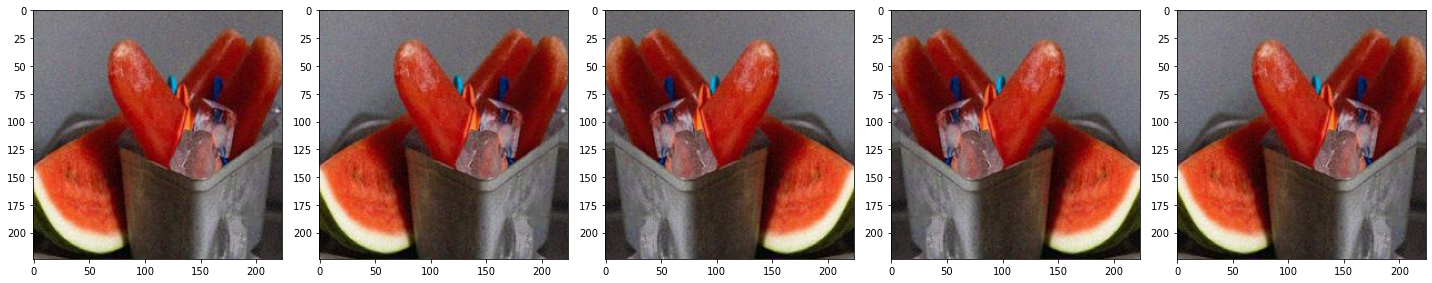

In [5]:
# # This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [my_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [7]:
siamese_model = SiameseModel(model)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001))


In [8]:
# pred = siamese_model.predict((gen1.next(),gen2.next(),gen3.next()))
pred = siamese_model.predict(my_gen.__getitem__(5))
print(my_gen.__getitem__(5)[0])

[[[[0.6745098  0.70980394 0.63529414]
   [0.6666667  0.7686275  0.6627451 ]
   [0.6627451  0.79215693 0.67058825]
   ...
   [0.03529412 0.01176471 0.0509804 ]
   [0.04705883 0.02352941 0.0627451 ]
   [0.07843138 0.04705883 0.09019608]]

  [[0.7254902  0.7607844  0.6862745 ]
   [0.70980394 0.80392164 0.7019608 ]
   [0.6901961  0.8196079  0.69803923]
   ...
   [0.04313726 0.01960784 0.05882353]
   [0.0509804  0.02745098 0.06666667]
   [0.07450981 0.04313726 0.08627451]]

  [[0.7607844  0.77647066 0.70980394]
   [0.72156864 0.8117648  0.70980394]
   [0.69803923 0.8117648  0.69411767]
   ...
   [0.03921569 0.01568628 0.05490196]
   [0.04313726 0.01960784 0.05882353]
   [0.05882353 0.02745098 0.07058824]]

  ...

  [[0.82745105 0.8980393  0.8117648 ]
   [0.8078432  0.87843144 0.79215693]
   [0.7843138  0.854902   0.7686275 ]
   ...
   [0.14509805 0.13725491 0.14117648]
   [0.10980393 0.13333334 0.13333334]
   [0.         0.01568628 0.00784314]]

  [[0.8352942  0.9058824  0.8196079 ]
   [0.8

In [9]:
# print(my_gen.__getitem__(5)[0])

In [10]:
train_steps_per_epoch = int((59520)/batch_size)
# train_steps_per_epoch = int((59520*5)/batch_size)

# checkpoint_filepath = './checkpoint'
checkpoint_filepath = './checkpoint-{epoch}/'
# checkpoint_filepath = "saved-model-{epoch}.hdf5"
# checkpoint_filepath = "saved-model-{epoch}"
#save checkpoint after every epoch
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
)

# siamese_model.fit(my_gen, epochs=5,steps_per_epoch=3,batch_size=batch_size,callbacks=[model_checkpoint_callback])
siamese_model.fit(my_gen, epochs=1,steps_per_epoch=train_steps_per_epoch,batch_size=batch_size,callbacks=[model_checkpoint_callback])
# siamese_model.fit_generator(my_gen,
#                         steps_per_epoch=train_steps_per_epoch,
#                         epochs=5
#                         )

  76/2480 [..............................] - ETA: 5:06 - loss: 0.3711

In [ ]:

# model_path = "siamese_model"
# tf.saved_model.save(siamese_model, model_path)
